# PCA - MNIST

En éste ejercicio vamos a aplicar PCA y K-means al digits dataset similar a MNIST, que incluye imágenes de dígitos de 8x8 píxeles. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [303]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize 
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize 
from sklearn.datasets import load_digits
from sklearn import metrics
from sklearn.cluster import KMeans

In [304]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Importamos el dataset

In [305]:
# Cargamos los datos de training
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [306]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


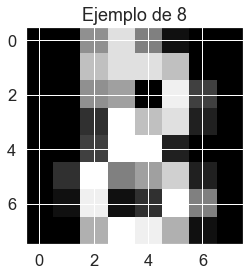

In [307]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')


---

## Consignas

### Paso 1. Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?

In [308]:
# Estandarizamos
scaler = StandardScaler()

X_escalada = normalize(X)
#X_escalada = scaler.fit_transform(X)

#Calculo PCA con 90% de la varianza
RANDOM_STATE = 17
varianza_requerida = 0.9
pca = PCA(n_components=varianza_requerida, random_state=RANDOM_STATE).fit(X_escalada)
X_pca = pca.transform(X_escalada)

# Veo la Cantidad de componentes necesarios
cant_componentes = X_pca.shape[1]
print("Componentes requeridas de PCA para llegar a 90% varianza: ",cant_componentes)


Componentes requeridas de PCA para llegar a 90% varianza:  21


### Paso 2. Graficar un screen plot (varianza contemplada en función del número de componentes considerados)

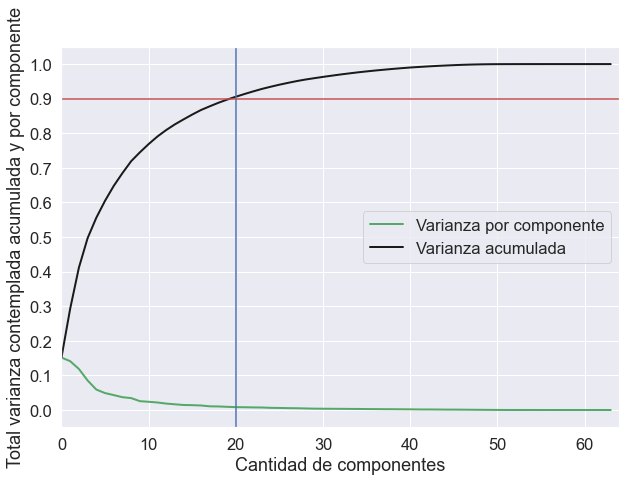

In [309]:
cant_features = X.shape[1]
pca_2 = PCA(n_components=cant_features, random_state=RANDOM_STATE).fit(X_escalada)
X_pca2 = pca_2.transform(X_escalada)

plt.figure(figsize=(10,7))
plt.plot(pca_2.explained_variance_ratio_, color='g', lw=2)
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada acumulada y por componente')
plt.xlim(0, cant_features)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(x,values)
plt.axvline(cant_componentes-1, c='b')
plt.axhline(varianza_requerida, c='r')
plt.legend(['Varianza por componente', 'Varianza acumulada'],loc="center right")
plt.show();



### Paso 3 Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL]

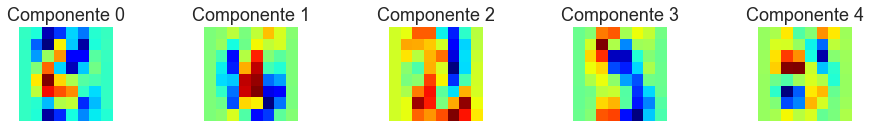

In [310]:
# Ploteo los 5 primeros componentes
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(pca.components_[i,:].ravel().reshape((8, 8)), cmap='jet') 
    plt.title('Componente {0}'.format(i)) 
    plt.axis('off')

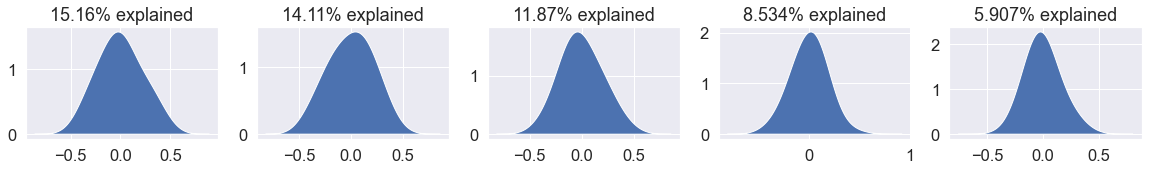

In [315]:
#Ploteo la varianza explicada de cada componente
plt.figure(figsize=(20,12))
for i in range(5):

    # Valor arbitrario
    sigmaOfKDE = 0.12
    pdfStart   = min(X_pca[:,i]) - 3*sigmaOfKDE
    pdfStop    = max(X_pca[:,i]) + 3*sigmaOfKDE
    xAxis = np.linspace(pdfStart,pdfStop,200)
    PDF_Model = KernelDensity(kernel='gaussian', 
                    bandwidth=sigmaOfKDE).fit(X_pca[:,i].reshape(-1,1))
    logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
    plt.subplot(5,5,i+1)
    plt.fill(xAxis, np.exp(logPDF), fc='b')
    percentExplainedString = str(100*pca.explained_variance_ratio_[i])[0:5]
    plt.title(percentExplainedString + '% explained') 


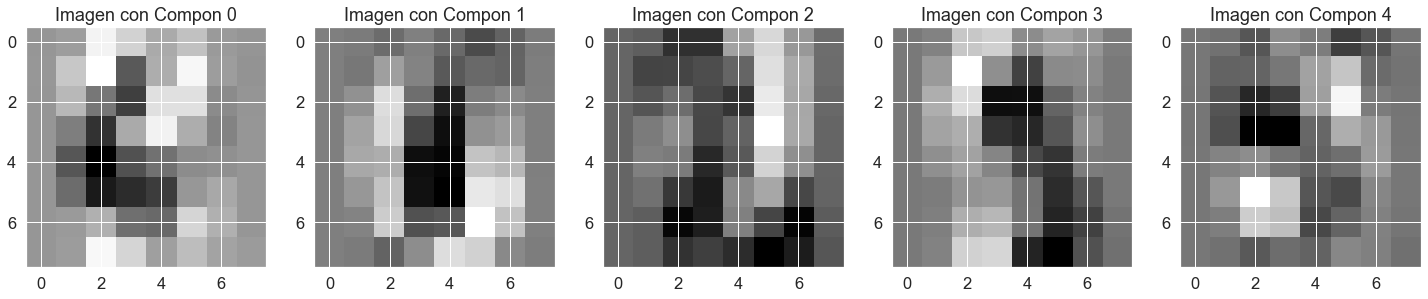

In [322]:
#Ploteo imagen original segun cada componente
plt.figure(figsize=(25,12))
plt.grid(True)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title('Imagen con Compon {0}'.format(i))     
    componenetei = pca.components_[i].reshape(len(pca.components_[i]),1)
    X_componenetei = ((X_escalada @ componenetei)) @ (componenetei.T)
    plt.imshow(X_componenetei[0, :].reshape((8, 8)), cmap='gray')


### Paso 4. Visualizar la imagen original vs. la reconstruida con los $m$ componentes del punto 1.

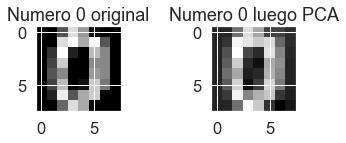

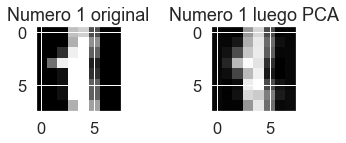

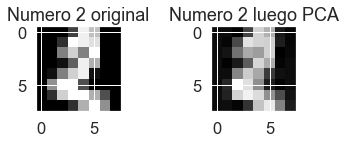

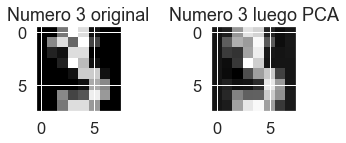

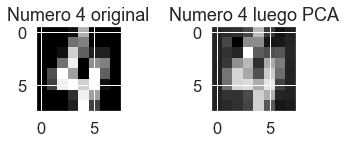

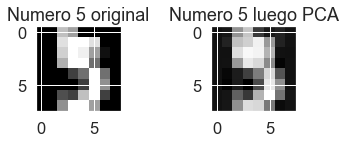

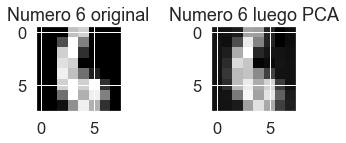

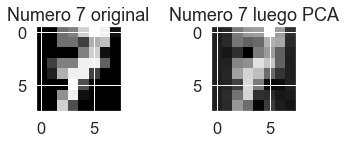

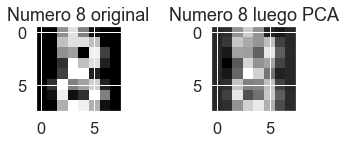

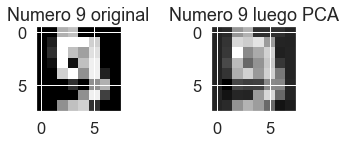

In [323]:
num_digitos = 10
X_pca_inv = pca.inverse_transform(X_pca)
plt.grid(True)
for i in range(num_digitos):
    # Ploteo el numero original
    plt.subplot(1, 2, 1)  
    titulo = "Numero " + str(y[i]) + " original"
    plt.title(titulo)
    plt.imshow(X[i, :].reshape((8, 8)), cmap='gray')

    # Ploteo el numero reconstruido
    plt.subplot(1, 2, 2) 
    titulo = "Numero " + str(y[i]) + " luego PCA"
    plt.title(titulo)
    plt.imshow(X_pca_inv[i, :].reshape((8,8 )), cmap='gray')
    plt.tight_layout(4) 
    plt.show()    


### Paso 5. Graficar una matriz de correlación del dataset reducido.

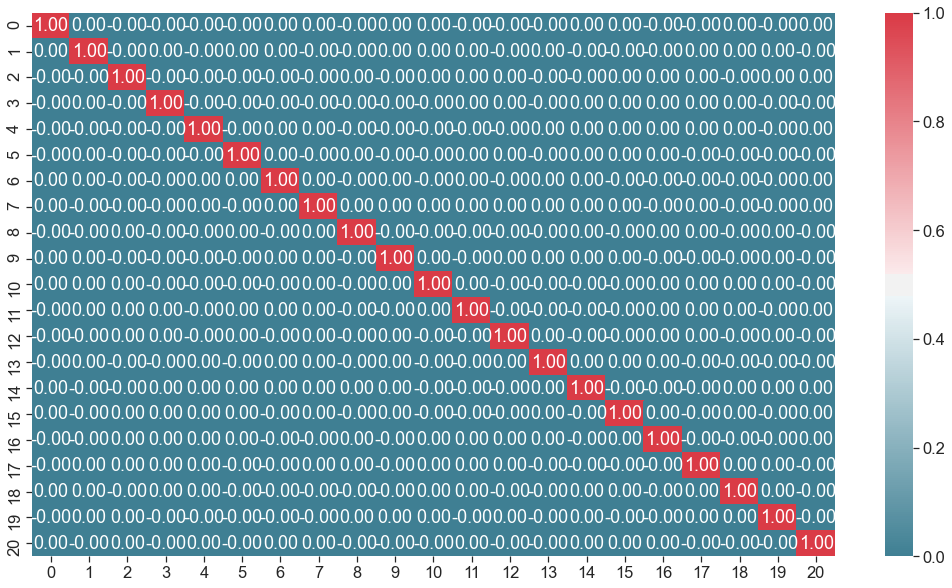

In [324]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

ds_reducido = pd.DataFrame(X_pca)
corr = ds_reducido.corr()
fig, ax1 = plt.subplots(1, figsize=(18, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1.5)

### Paso 6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.

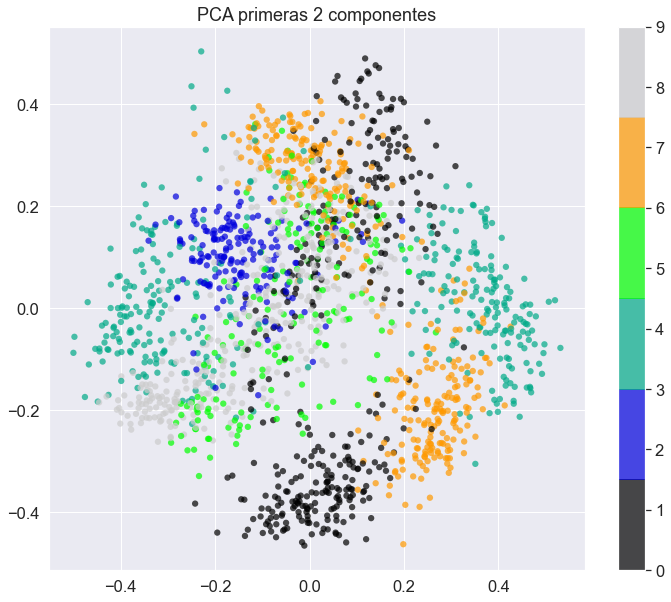

In [325]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('PCA primeras 2 componentes');

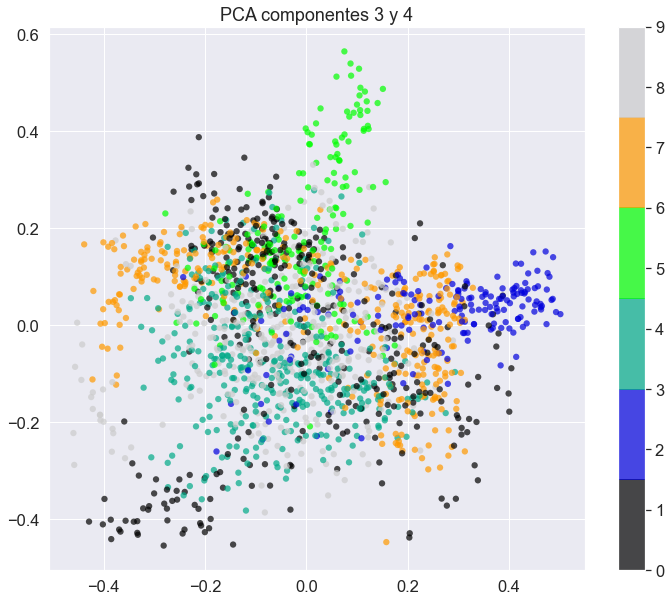

In [326]:
# Graficamos los componenetes 3 y 4
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 2], X_pca[:, 3], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('PCA componentes 3 y 4');

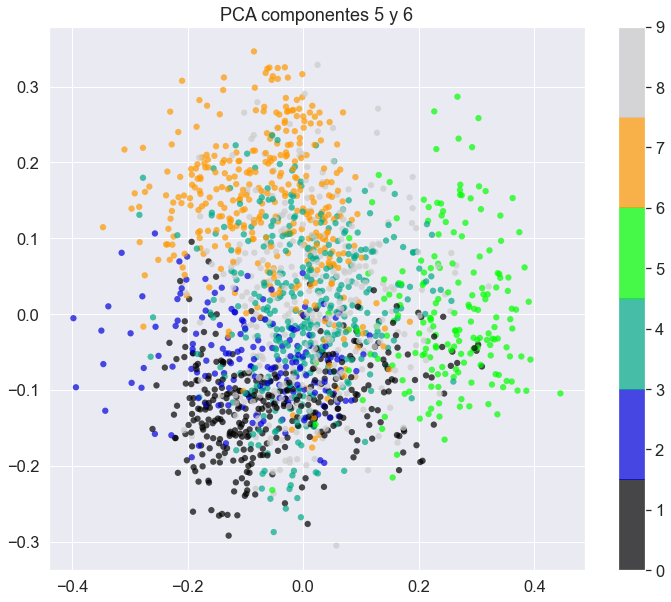

In [327]:
# Graficamos los componenetes 5 y 6
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 4], X_pca[:, 5], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('PCA componentes 5 y 6');

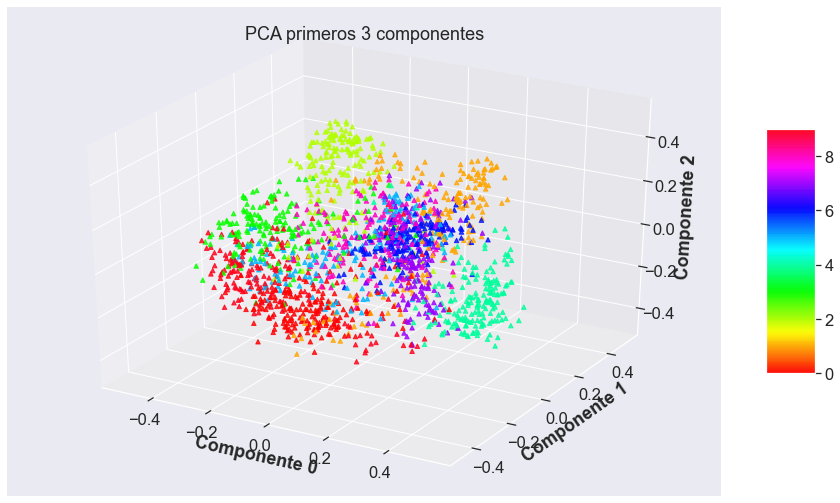

In [328]:
#Muestro las primeras 3 compoenentes juntas
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')
 
sctt = ax.scatter3D(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], 
                    alpha = 0.8,
                    c=y,
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("PCA primeros 3 componentes")
ax.set_xlabel('Componente 0', fontweight ='bold')
ax.set_ylabel('Componente 1', fontweight ='bold')
ax.set_zlabel('Componente 2', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
plt.show()

### Paso 7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?

In [330]:
kmeans = KMeans(n_clusters=10, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Analizamos los resultados en el paso 9 luego de graficar y comparar los clusters originales contra los obtenidos por kmenas

### Paso 8. Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.


In [331]:
# Vemos la inercia (suma de las distancias de los miembros de un cluster a su centroide)
inertia = []
for k in range(1, num_digitos + 4):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

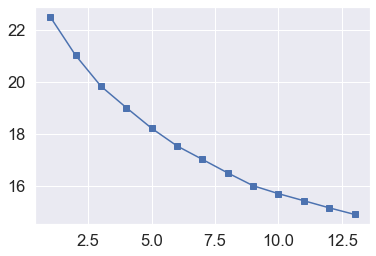

In [332]:
plt.plot(range(1, num_digitos+4), inertia, marker='s')

In [333]:
coef_d = {}
for k in range(2, num_digitos+3):
    i = k - 1
    coef_d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])
    
print("Valores de D(K):\n")
for key,val in coef_d.items():
    print("{0:5} : {1}".format(key,val))

Valores de D(K):

    2 : 0.802359501071395
    3 : 0.6938709678423873
    4 : 0.9632475464899081
    5 : 0.8549061671780368
    6 : 0.7609955601078873
    7 : 1.0085257204148015
    8 : 0.9439001115253018
    9 : 0.6226297152827908
   10 : 0.8848840389317225
   11 : 1.0078898357730288
   12 : 0.9290350869750811


De acuerdo al valor de inercia y de D(K) el valor optimo podria estar en k =9

### Paso 9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

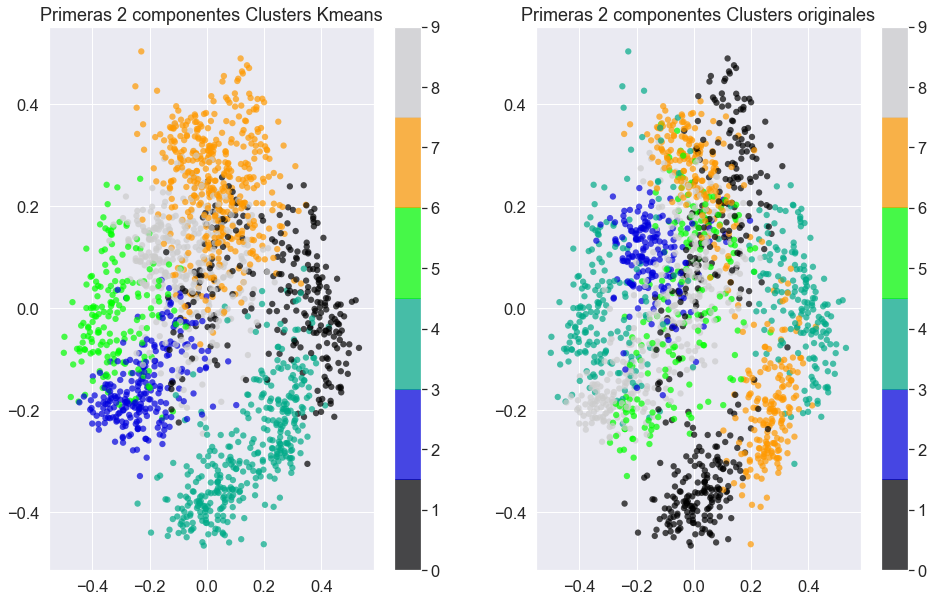

In [348]:
# Graficamos los primeros dos componentes contra clusters de kmeans
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Primeras 2 componentes Clusters Kmeans');

# Graficamos los primeros dos componentes contra clusters originales
plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Primeras 2 componentes Clusters originales');


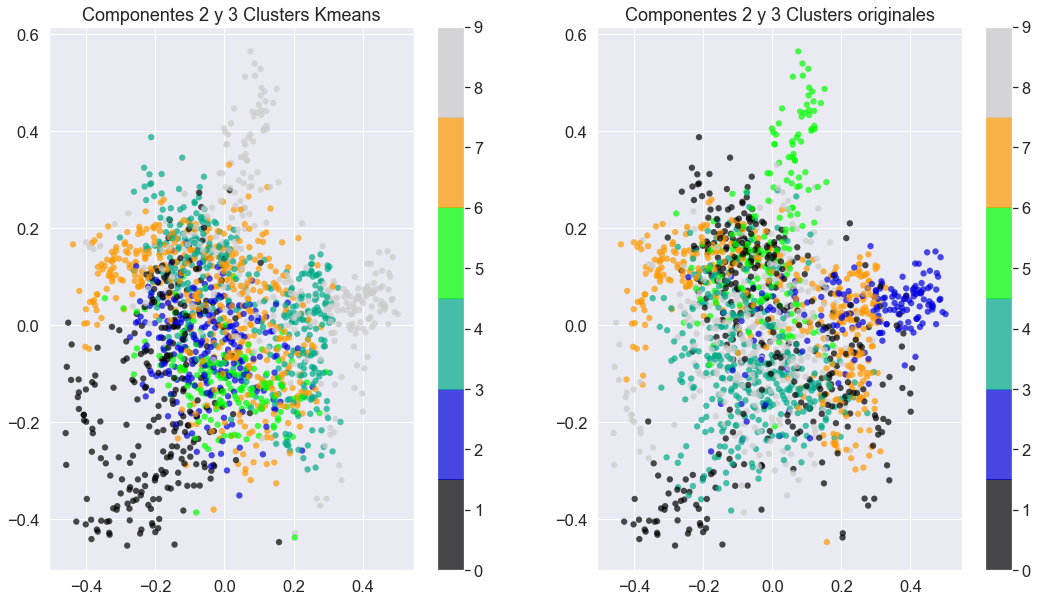

In [350]:
# Graficamos los componentes 3 y 4 contra clusters kmenas
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 2], X_pca[:, 3], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Componentes 2 y 3 Clusters Kmeans');

# Graficamos los componentes 3 y 4 contra clusters originales
plt.subplot(1,2,2)
plt.scatter(X_pca[:, 2], X_pca[:, 3], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Componentes 2 y 3 Clusters originales');

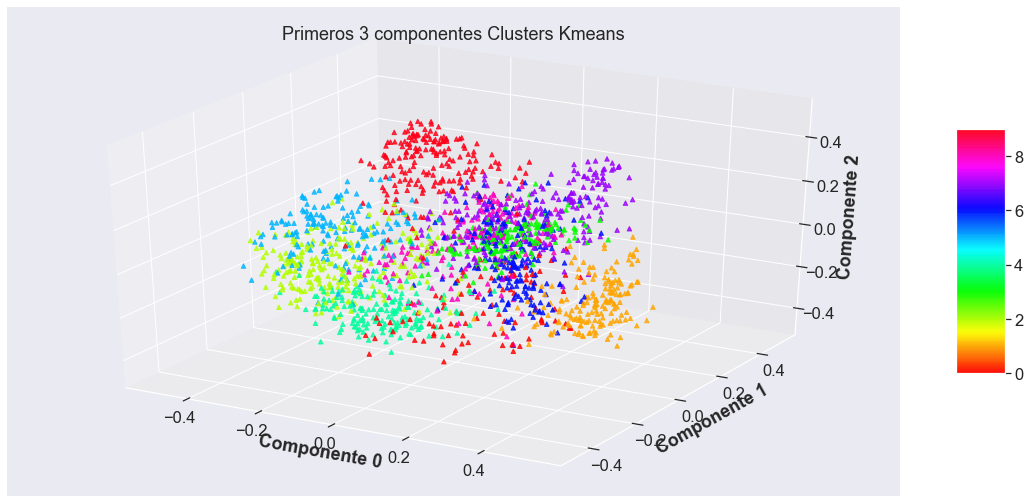

In [351]:
# Comparamos los primeros 3 compoenentes juntos
fig = plt.figure(figsize = (20, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')

sctt = ax.scatter3D(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], 
                    alpha = 0.8,
                    c=cluster_labels,
                    cmap = my_cmap,
                    marker ='^')
plt.title("Primeros 3 componentes Clusters Kmeans")
ax.set_xlabel('Componente 0', fontweight ='bold')
ax.set_ylabel('Componente 1', fontweight ='bold')
ax.set_zlabel('Componente 2', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()


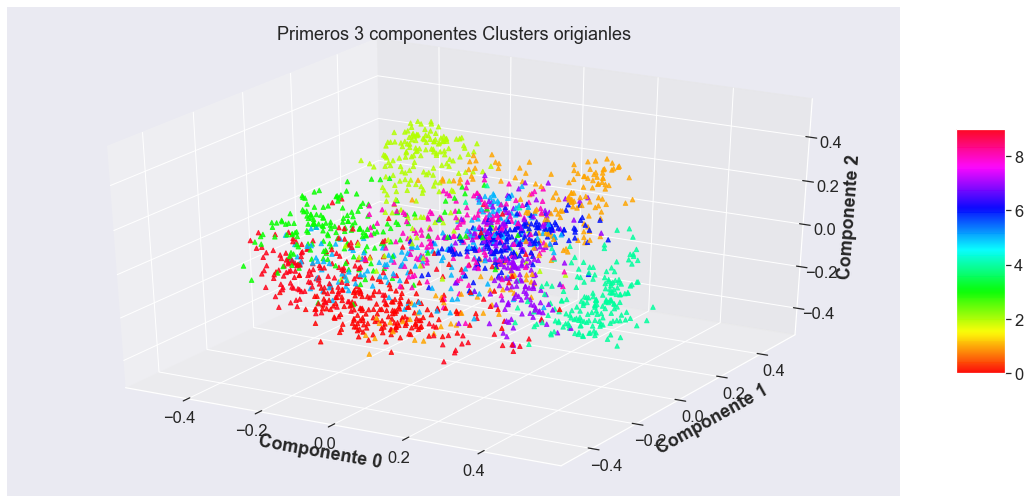

In [352]:
fig = plt.figure(figsize = (20, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')

sctt = ax.scatter3D(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], 
                    alpha = 0.8,
                    c=y,
                    cmap = my_cmap,
                    marker ='^')
plt.title("Primeros 3 componentes Clusters origianles")
ax.set_xlabel('Componente 0', fontweight ='bold')
ax.set_ylabel('Componente 1', fontweight ='bold')
ax.set_zlabel('Componente 2', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

### Conclusiones

Los clusters obtenidos por Kmeans se corresponden en gran medida contra los clusters originales del dataset, analizando las primeras 4 compoenentes